In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import shape
from scipy import stats 
import seaborn as sns
import numpy as np
from scipy.stats.distributions import gamma
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import scale

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(10, 10)})

In [ ]:
# Step 1. Choose about 3-6 variables from your dataset (2-3 – target variables, the rest -
# predictors).

In [8]:
df = pd.read_csv('data/FW_Veg_Rem_Combined.csv')
df = df.iloc[:, 2:]

df = df[df['disc_pre_year'] > 1991]

In [9]:
cont_columns_prefix = ['Prec_pre_', "Temp_pre_", "Wind_pre_", "Hum_pre_"]
columns_suffix = [7, 15, 30]

weather_columns = [ x + str(y) for x in cont_columns_prefix for y in columns_suffix]
# not realistic values, probably just a stub on values (all equal -1 or all equal 0)
#df = df[(df.loc[:, weather_columns] != -1).all(axis=1) & (df.loc[:, weather_columns] != 0).all(axis=1)]

#columns we are going to take in analysis 
weather_columns = [x for x in weather_columns if '7' in x or '15' in x]
df['day'] = pd.to_datetime(df['disc_clean_date']).map(lambda x: x.day)

In [20]:
df['day'] = pd.to_datetime(df['disc_clean_date']).map(lambda x: x.day)
df['month'] = pd.to_datetime(df['disc_clean_date']).map(lambda x: x.month)

In [32]:
month_map = {x: y for x, y in  list(zip(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], range(1, 13)))}
reverse_month_map = {y: x for x, y in month_map.items()}

In [46]:
df['day'] = pd.to_datetime(df['disc_clean_date']).map(lambda x: x.day)
df['month'] = pd.to_datetime(df['disc_clean_date']).map(lambda x: x.month)
cont_columns_prefix = ['Prec_pre_', "Temp_pre_", "Wind_pre_", "Hum_pre_"]
fire_count_columns =["disc_pre_year", "discovery_month", 'month'] + [ x + '30' for x in cont_columns_prefix]

df_fires_count = df.groupby(['disc_pre_year', 'discovery_month', 'month']).size().reset_index().rename({0: 'count'}, axis=1)

data_fire_count = df.sort_values(['disc_pre_year', 'month', 'day'],
    ascending=False).drop_duplicates(['disc_pre_year', 'discovery_month'], keep='first')[fire_count_columns]

df_count = df_fires_count.merge(data_fire_count)

In [47]:
df_count.sort_values(['disc_pre_year', 'month'])

,disc_pre_year,discovery_month,month,count,Prec_pre_30,Temp_pre_30,Wind_pre_30,Hum_pre_30
0,1991,Jan,1,106,0.0,3.380000,2.680000,83.400000
5,1992,Jan,1,38,0.0,3.711273,3.049818,80.741818
4,1992,Feb,2,268,23.5,9.856860,3.556436,63.038348
8,1992,Mar,3,306,-1.0,-1.000000,-1.000000,-1.000000
1,1992,Apr,4,268,0.0,12.304323,4.519913,67.806886
...,...,...,...,...,...,...,...,...
278,2015,Aug,8,268,13.1,21.007802,3.976601,46.630890
288,2015,Sep,9,123,1.3,16.869158,4.330381,41.527248
287,2015,Oct,10,180,-1.0,-1.000000,-1.000000,-1.000000
286,2015,Nov,11,84,0.0,4.782953,3.408570,75.151457


In [56]:
df_count['disc_year_month'] = df_count['disc_pre_year'].astype(str) + df_count['month'].map(lambda x: '-' + str(x) if len(str(x)) == 2 else '-0' + str(x))
df_count.sort_values('disc_year_month', ascending=True, inplace=True)

/var/folders/52/jlsyyvjj0vdg38ntl40v6j1h0000gp/T/ipykernel_61048/2655378162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_count['disc_year_month'] = df_count['disc_pre_year'].astype(str) + df_count['month'].map(lambda x: '-' + str(x) if len(str(x)) == 2 else '-0' + str(x))


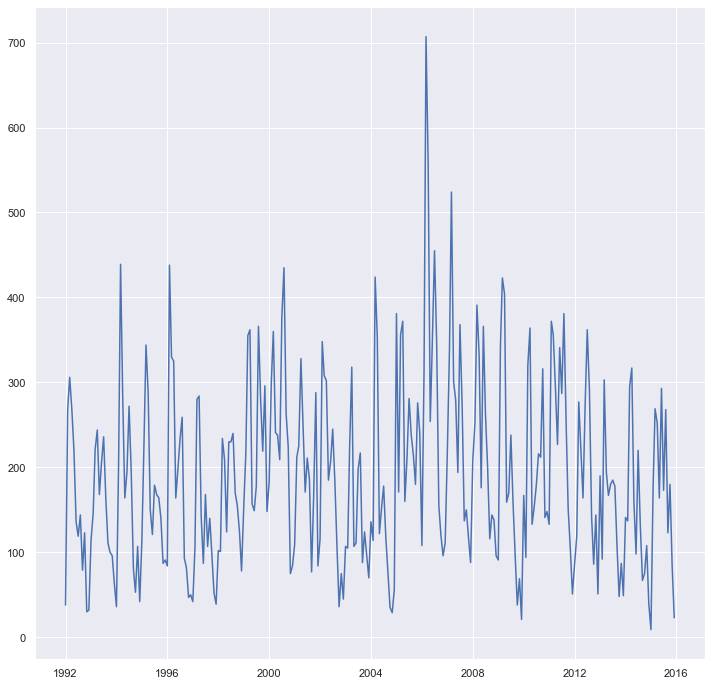

In [66]:
plt.plot(pd.to_datetime(df_count['disc_year_month']), df_count['count'])


In [76]:
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
#Analyze stationarity of a process (for mathematical expectation and variance) for all
#chosen variables. Make them more stationary if needed.
#

In [102]:
from statsmodels.tsa.api.stattools import adfuler

ModuleNotFoundError: No module named 'statsmodels.tsa.api.stattools'; 'statsmodels.tsa.api' is not a package

In [67]:
import statsmodels.tsa.api as smt


result = smt.stattools.adfuller(df_count['count'])
print('Augmented Dickey-Fuller test:\nStatistic value = %5f\np-value = %5f' % (result[0], result[1]))

Augmented Dickey-Fuller test:
Statistic value = -3.160861
p-value = 0.022365


In [100]:
result = smt.stattools.adfuller(df_count['count'])
print('Augmented Dickey-Fuller test:\nStatistic value = %5f\np-value = %5f' % (result[0], result[1]))

Augmented Dickey-Fuller test:
Statistic value = -3.160861
p-value = 0.022365


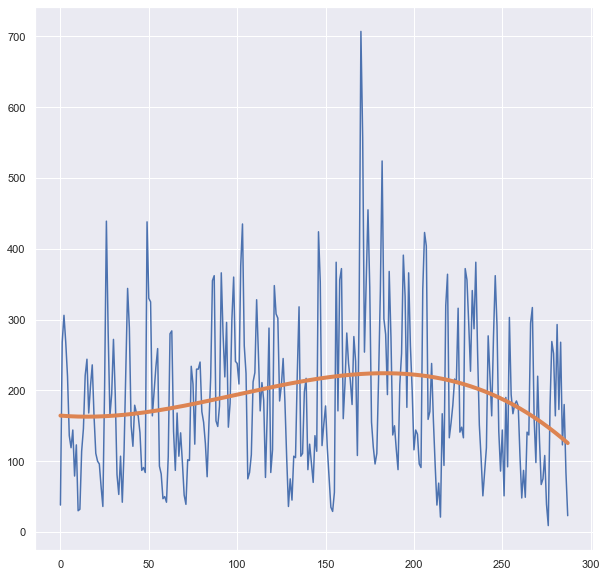

In [99]:
def trendline(data, order=9):
    #polynomial trend
    trend = np.polyfit(data.index.values, list(data), order)
    return np.poly1d(trend)(data.index.values)

trend = trendline(df_count['count'], 3)
plt.plot(df_count['count'])
plt.plot(trend, linewidth=4)
plt.show()

In [71]:
weather_columns = ['Prec_pre_30', 'Temp_pre_30', 'Wind_pre_30', 'Hum_pre_30']

In [ ]:
# Analyze covariance or correlation function for chosen target variables and mutual
# correlation functions among predictors and targets.

<AxesSubplot:>

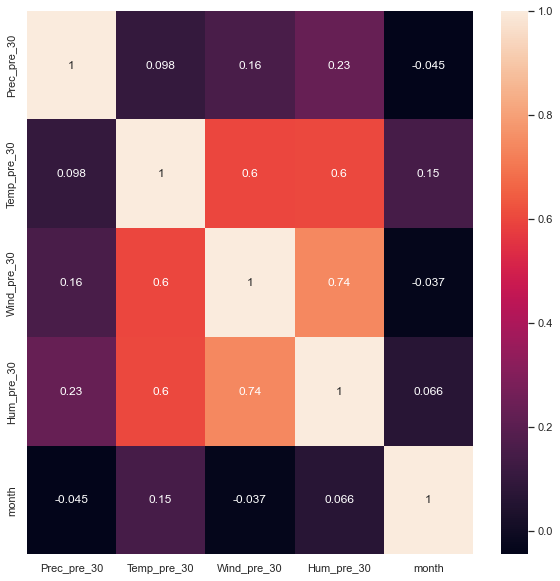

In [75]:
corrMatrix = df_count[weather_columns + ['month']].corr()
sns.heatmap(corrMatrix, annot=True)

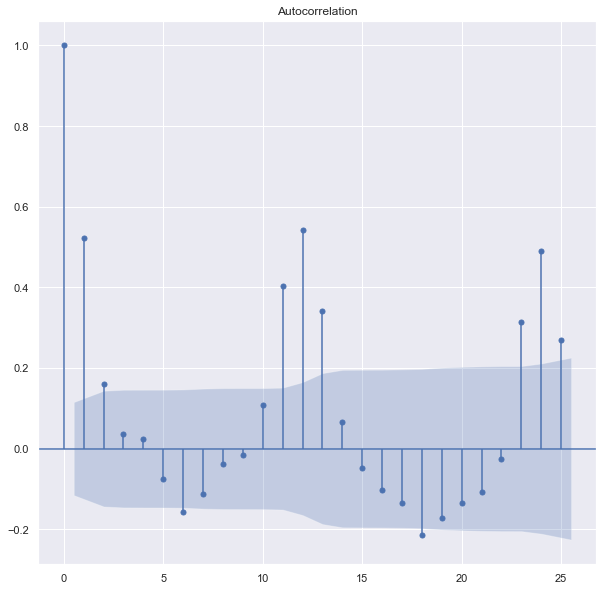

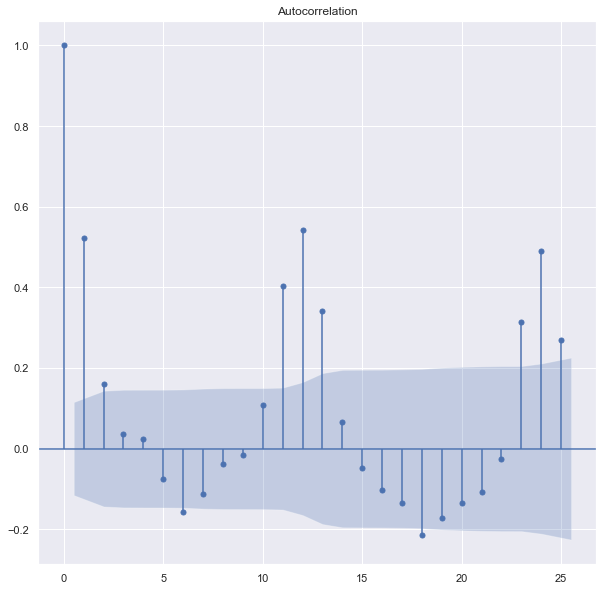

In [96]:
plot_acf(df_count['count'])

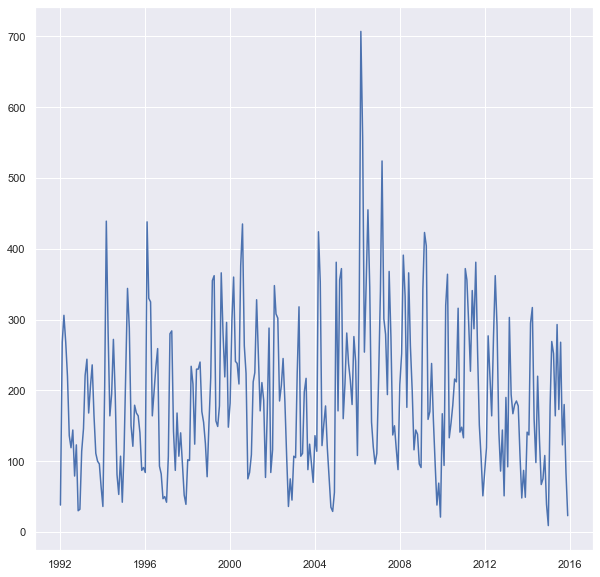

In [107]:
plt.plot(pd.to_datetime(df_count['disc_year_month']), df_count['count'])
plt.show()

In [ ]:
# You need to make an estimation of pair correlation coefficients, confidence intervals
# for them and significance levels.

In [85]:
df_count.head()

,disc_pre_year,discovery_month,month,count,Prec_pre_30,Temp_pre_30,Wind_pre_30,Hum_pre_30,disc_year_month
5,1992,Jan,1,38,0.0,3.711273,3.049818,80.741818,1992-01
4,1992,Feb,2,268,23.5,9.856860,3.556436,63.038348,1992-02
8,1992,Mar,3,306,-1.0,-1.000000,-1.000000,-1.000000,1992-03
1,1992,Apr,4,268,0.0,12.304323,4.519913,67.806886,1992-04
9,1992,May,5,220,-1.0,-1.000000,-1.000000,-1.000000,1992-05


In [87]:
for column in weather_columns + ['disc_pre_year', 'month']:
    # Confidence interval for the correlation coefficient
    x = df_count[column].apply(lambda x: float(x))
    y = df_count['count'].apply(lambda x: float(x))
    r, p = stats.pearsonr(x, y)
    r_z = np.arctanh(r) # matches Fisher transform
    # Corresponding standard deviation
    se = 1/np.sqrt(x.size-3)
    alpha = 0.05
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    print('fire_size and', column)
    print('Correlation coefficient = ', r)
    print("p-value:\t", p)
    print(f'Confidence interval for the correlation coefficient low: {lo_z}, high: {hi_z}')
    print('')

fire_size and Prec_pre_30
Correlation coefficient =  0.0662232706625702
p-value:	 0.2626333675212673
Confidence interval for the correlation coefficient low: -0.049777912613221356, high: 0.18241858072488665

fire_size and Temp_pre_30
Correlation coefficient =  0.06892789707953566
p-value:	 0.24359612024629665
Confidence interval for the correlation coefficient low: -0.0470608772776866, high: 0.1851356160604214

fire_size and Wind_pre_30
Correlation coefficient =  0.0820822247453998
p-value:	 0.1647510122202086
Confidence interval for the correlation coefficient low: -0.03383093034665338, high: 0.1983655629914546

fire_size and Hum_pre_30
Correlation coefficient =  -0.057014821704941765
p-value:	 0.33497064383146424
Confidence interval for the correlation coefficient low: -0.1731749683176779, high: 0.059021525020430086

fire_size and disc_pre_year
Correlation coefficient =  0.0740226531725443
p-value:	 0.2104016416855494
Confidence interval for the correlation coefficient low: -0.041939

In [94]:
df_count.reset_index(drop=True, inplace=True)

/var/folders/52/jlsyyvjj0vdg38ntl40v6j1h0000gp/T/ipykernel_61048/162195626.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_count['z_data'] = (df_count['count'] - df_count['count'].rolling(window=12).mean()) / df_count['count'].rolling(window=12).std()
/var/folders/52/jlsyyvjj0vdg38ntl40v6j1h0000gp/T/ipykernel_61048/162195626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_count['zp_data'] = df_count['z_data'] - df_count['z_data'].shift(12)


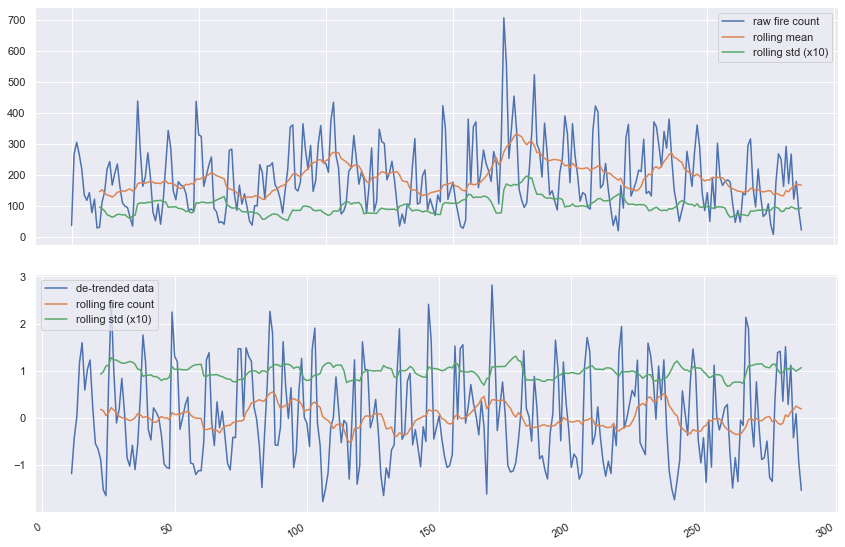

In [109]:
df_count['z_data'] = (df_count['count'] - df_count['count'].rolling(window=12).mean()) / df_count['count'].rolling(window=12).std()
df_count['zp_data'] = df_count['z_data'] - df_count['z_data'].shift(12)

def plot_rolling(df):
    fig, ax = plt.subplots(2,figsize=(12, 9))
    ax[0].plot(df.index, df['count'], label='raw fire count')
    ax[0].plot(df['count'].rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df['count'].rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df.z_data.rolling(window=12).mean(), label="rolling fire count");
    ax[1].plot(df.z_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

plot_rolling(df_count)

In [110]:
print(" > Is the data stationary ?")
dftest = smt.stattools.adfuller(df_count['count'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = smt.stattools.adfuller(df_count['z_data'].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -3.161
P-value = 0.022
Critical values :
	1%: -3.4546223782586534 - The data is not stationary with 99% confidence
	5%: -2.8722253212300277 - The data is  stationary with 95% confidence
	10%: -2.5724638500216264 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -3.619
P-value = 0.005
Critical values :
	1%: -3.4552699038400827 - The data is  stationary with 99% confidence
	5%: -2.8725092359464526 - The data is  stationary with 95% confidence
	10%: -2.5726152830188678 - The data is  stationary with 90% confidence


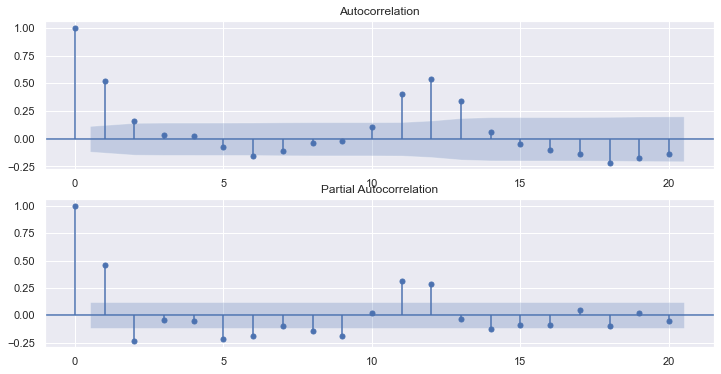

In [111]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df_count['count'], ax=ax[0], lags=20)
ax[1] = plot_pacf(df_count.z_data.dropna(), ax=ax[1], lags=20)

In [112]:
df_count.shape

(288, 11)

In [119]:
int(df_count['disc_pre_year'].nunique() * 0.85) * 12

240

In [128]:
df_count['disc_year_month'] = pd.to_datetime(df_count['disc_year_month'])

/var/folders/52/jlsyyvjj0vdg38ntl40v6j1h0000gp/T/ipykernel_61048/1410150622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_count['disc_year_month'] = pd.to_datetime(df_count['disc_year_month'])


In [129]:
time_series = df_count.set_index('disc_year_month')

In [140]:
train_num_split = int(df_count['disc_pre_year'].nunique() * 0.85) * 12

train = time_series.iloc[:train_num_split, :]
test = time_series.iloc[train_num_split:, :]

In [132]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

model = Holt(np.asarray(train['count']))
model._index = train.index

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(9)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(9)
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(9)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend();

/Users/ipavelyev/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/var/folders/52/jlsyyvjj0vdg38ntl40v6j1h0000gp/T/ipykernel_61048/1163989716.py:6: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)


TypeError: unsupported operand type(s) for +: 'Timestamp' and 'NoneType'

In [ ]:
#Filter high frequencies (noise) with chosen 2 filters for target variables.
